In [1]:
import os
import sys
sys.path.append("../")
import argparse
import time
import pickle
from ALImisc import *
from ALImodel import *
from ALIloader import *
from sklearn import metrics
from sklearn import manifold
import seaborn as sns
import pandas as pd

In [2]:

LS = 512 #Latent Space Size
ColorsNumber = 1 #Number of color (always 1 for x-ray)
isize = 64
inputsize = 64
name = "Exp_64_512_0.00001_RandomLabel_4.0"
#name = "todel2"
datadir = "/media/vince/MILA/Chest_data/"

ExpDir = "/media/vince/MILA/ChestXrays/ALI/model/"+name


In [3]:
#Load train and test

TestDataset = LoadTrainTestSet(datadir+"ChestXray-NIHCC-2/",inputsize,rseed=13,subset="Test")
TrainDataset = LoadTrainTestSet(datadir+"ChestXray-NIHCC-2/",inputsize,rseed=13,N=len(TestDataset))
#Load MNIST
MNIST = LoadMNIST(datadir+"MNIST/",inputsize)

#Load MURA
MURA = LoadMURA(datadir+"MURA-v1.1/*/",inputsize,N=-1,rseed=13)

#Load Pneunomia
Pneuno = LoadPneunomia(datadir+"/chest_xray/*/*",inputsize,N=-1,rseed=13)

#Modified Chest X-ray 
Hflip,Vflip,Shuffle,Random,Mean = LoadModChest(datadir+"ChestXray-NIHCC-2/",64,rseed=13)



In [4]:
def LoadCIFAR(datadir,isize):
    #Load MNIST
    CIFAR_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize(isize),transforms.ToTensor()])
    CIFAR_set = dset.CIFAR100(root=datadir, train=True, transform=CIFAR_transform, download=True)
    
    return(CIFAR_set)
CIFAR = LoadCIFAR(datadir+"MNIST/",inputsize)






Files already downloaded and verified


In [33]:
def LoadSTL10(datadir,isize):
    STL10_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize(isize),transforms.ToTensor()])
    STL10_set = dset.STL10(root=datadir, split="train", transform=STL10_transform, download=False)
    return(STL10_set)
STL10 = LoadSTL10(datadir+"MNIST/",inputsize)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [7]:
DsetName = ["ChestXray","tChestXray","CIFAR","MNIST","MURA","Pneuno","hFlip","vFlip","Shuffle","Random","Mean"]
Dset = [TestDataset,TrainDataset,CIFAR,MNIST,MURA,Pneuno,Hflip,Vflip,Shuffle,Random,Mean]
for (d,n) in zip(Dset,DsetName):
    print(n,len(d))

ChestXray 367
tChestXray 367
CIFAR 50000
MNIST 60000
MURA 3197
Pneuno 5856
hFlip 367
vFlip 367
Shuffle 367
Random 367
Mean 367


In [8]:
#Get all Modeled saved
SavedModelsIT = []
for SavedFiles in glob.glob('{0}/models/*_DisXZ_It_*.pth'.format(ExpDir)):
    #print(fck)
    nck = SavedFiles.split("_")[-1].split(".")[0]
    SavedModelsIT.append(int(nck))
SavedModelsIT = sorted(SavedModelsIT)
print("Saved Model",SavedModelsIT)

Saved Model [10100, 101000, 1010000, 1020100, 1030200, 1040300, 1050400, 1060500, 1070600, 1080700, 1090800, 2121000]


In [9]:
DsetName = ["ChestXray","tChestXray","CIFAR","MURA","Pneuno"]
Dset = [TestDataset,TrainDataset,CIFAR,MURA,Pneuno]

In [10]:
Params = dict()
Params["name"] = name

In [11]:
AllAUCs = dict()
for cp in sorted(SavedModelsIT)[::-1]:
    #Load current iteration
    
    DisX,DisZ,DisXZ,GenZ,GenX,CP,DiscriminatorLoss,tAUCs = GenModel(
        inputsize,LS,cp,ExpDir,Params["name"],ColorsNumber=ColorsNumber)
    for cp in tAUCs:
        if cp in AllAUCs:continue
        for met in tAUCs[cp]:
            if cp not in AllAUCs:AllAUCs[cp] = dict()
            
            #AllAUCs[cp][met] = tAUCs[cp][met]
    print("Iterations",cp,CP)
    cp = int(CP)
    #if cp in AllAUCs:
    #    continue
    
    
    #Set to eval
    GenX.eval()
    GenZ.eval()
    DisX.eval()
    DisZ.eval()
    DisXZ.eval()
    
    #Where to Store data
    AllEvalData = dict()
    for (d,n) in zip(Dset,DsetName):
        print(n)
        AllEvalData[n] = dict()
        #Array to store data
        TDiscSc = []
        TRecErr = []
        TZ = []
        TX = []
        TXr = []
        TDiff = []
        tlab = []
        L1 = []
        for Xi,path in DataLoader(d,shuffle=False, batch_size=50):
            rXi = Xi*2.0-1.0
            if torch.cuda.is_available():
                rXi = rXi.cuda()
            ttlab = []
            if (n == "MNIST") or (n=="CIFAR"):
                ttlab = list(path.detach().numpy())
            else:
                ttlab += list(path[1])
            #Calculate Error    
            DiscSc,RL,Z,Xr,DiffX = EvalImage(GenX,GenZ,DisXZ,DisX,DisZ,rXi)
            
            
            for x in DiffX:
                L1.append(np.median(np.abs(x)))

            
            #Store everything
            if torch.cuda.is_available():
                rXi = rXi.cpu()
                
            TX += list(rXi.detach().numpy())
            TDiscSc += DiscSc
            TRecErr += RL
            TZ += Z
            TXr += list(Xr)
            TDiff += list(DiffX)
            tlab += ttlab
            #test_size = len(TestDataset)
            test_size = 10000
            if len(TZ) >= test_size:
                L1 = L1[:test_size]
                TZ = TZ[:test_size]
                TX = TX[:test_size]
                TDiscSc = TDiscSc[:test_size]
                TRecErr = TRecErr[:test_size]
                TXr  = TXr[:test_size]
                TDiff  = TDiff[:test_size]
                tlab = tlab[:test_size]
                break
    
        AllEvalData[n]["Z"] = TZ
        AllEvalData[n]["X"] = TX
        AllEvalData[n]["RecLoss"] = TRecErr
        AllEvalData[n]["Dis"] = TDiscSc
        AllEvalData[n]["Xr"] = TXr
        AllEvalData[n]["DiffX"] = TDiff
        AllEvalData[n]["lab"] = tlab
        AllEvalData[n]["L1"] = L1
    Zn = AllEvalData["tChestXray"]["Z"]
    for name in DsetName:
        tDist = []
        udist = []
        for Zi in AllEvalData[name]["Z"]:
            dist = np.sum(np.power(np.array(Zn)-Zi,2),axis=1)
            tDist.append(np.min(dist))
            udist.append(np.sum(np.power(Zi,2)))
        AllEvalData[name]["tDist"] = tDist
        AllEvalData[name]["Dist"] = udist
    #Print Reconstruction process
    break
    cp = int(CP)
    sf = ExpDir+"/images/RecLoss/Recon_"+"%010d.png" % (cp)
    ImageReconPrint(AllEvalData,DsetName,SaveFile=sf)
    
    #Print Distribution of image
    sf = ExpDir+"/images/RecLoss/ImgDist_"+"%010d.png" % (cp)
    PrintDense(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","MURA","Pneuno","CIFAR"],SaveFile=sf)
    sf = ExpDir+"/images/RecLoss/SynthDist_"+"%010d.png" % (cp)
    PrintDense(AllEvalData,DsetName,ToPrint=["ChestXray","hFlip","vFlip","Shuffle","Random","tChestXray","Mean"],SaveFile=sf)
    
    
    #Print T-SNE
    #df = GetTSNE(AllEvalData,ToPrint = ["ChestXray","MNIST","MURA","Pneuno","Shuffle","vFlip","CIFAR"])
    #sf = ExpDir+"/images/RecLoss/TSNE_"+"%010d.png" % (cp)
    #PrintTSNE(df,ToPrint = ["ChestXray","MNIST","MURA","Pneuno","Shuffle","vFlip","Mean"],MaxPlot=300,SaveFile=sf)
    
    #Print Sorted error
    sf = ExpDir+"/images/RecLoss/SortErr_"+"%010d.png" % (cp)
    ImageSortPrint(AllEvalData,DsetName,SaveFile=sf)
    cp = int(CP)
    #Get AUC recloss
    tAUC = GetAUC(AllEvalData,metric="RecLoss")
    if cp not in AllAUCs:
        AllAUCs[cp] = dict()
    AllAUCs[cp]["AUCrl"] = tAUC
    
    #Get AUC Discriminator
    tAUC = GetAUC(AllEvalData,metric="Dis")
    if cp not in AllAUCs:
        AllAUCs[cp] = dict()
    AllAUCs[cp]["AUCdis"] = tAUC
    
    #Get AUC Discriminator
    tAUC = GetAUC(AllEvalData,metric="L1")
    if cp not in AllAUCs:
        AllAUCs[cp] = dict()
    AllAUCs[cp]["AUCL1"] = tAUC
    
    #Get Loss for every dataset
    if "Url" not in AllAUCs[cp]:AllAUCs[cp]["Url"] = dict()
    if "Udis" not in AllAUCs[cp]:AllAUCs[cp]["Udis"] = dict()
    if "Drl" not in AllAUCs[cp]:AllAUCs[cp]["Drl"] = dict()
    if "Ddis" not in AllAUCs[cp]:AllAUCs[cp]["Ddis"] = dict()    
    for n in AllEvalData:
        AllAUCs[cp]["Url"][n] = np.mean(AllEvalData[n]["RecLoss"])
        AllAUCs[cp]["Udis"][n] = np.mean(AllEvalData[n]["Dis"])
        
        AllAUCs[cp]["Drl"][n] = np.std(AllEvalData[n]["RecLoss"])
        AllAUCs[cp]["Ddis"][n] = np.std(AllEvalData[n]["Dis"])
    
    pickle.dump(AllAUCs, open( '{0}/models/{1}_AUCs_It_{2}.pth'.format(ExpDir,Params["name"], cp), "wb" ))
    break

Checkpoint 2121000 exist, will load param and start training from there
/media/vince/MILA/ChestXrays/ALI/model/Exp_64_512_0.00001_RandomLabel_4.0/models/Exp_64_512_0.00001_RandomLabel_4.0_DisX_It_2121000.pth
Iterations 2121000 2121000
ChestXray
tChestXray
CIFAR
MURA
Pneuno


In [12]:

AllEvalData[n]["Z"] = TZ
AllEvalData[n]["X"] = TX
AllEvalData[n]["RecLoss"] = TRecErr
AllEvalData[n]["Dis"] = TDiscSc
AllEvalData[n]["Xr"] = TXr
AllEvalData[n]["DiffX"] = TDiff
AllEvalData[n]["lab"] = tlab
AllEvalData[n]["L1"] = L1

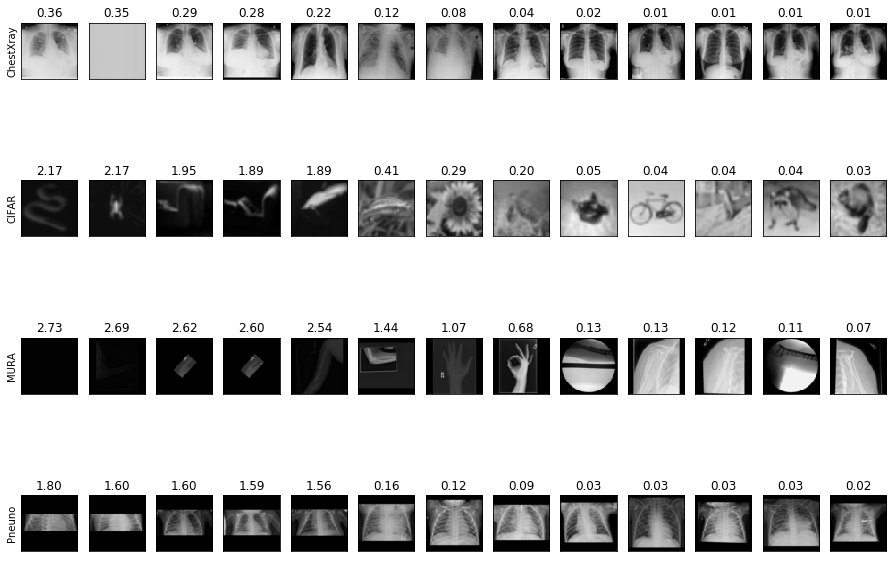

In [13]:

ImageSortPrint(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","CIFAR","MURA","Pneuno","Mean","Shuffle","vFlip"],metric="L1")

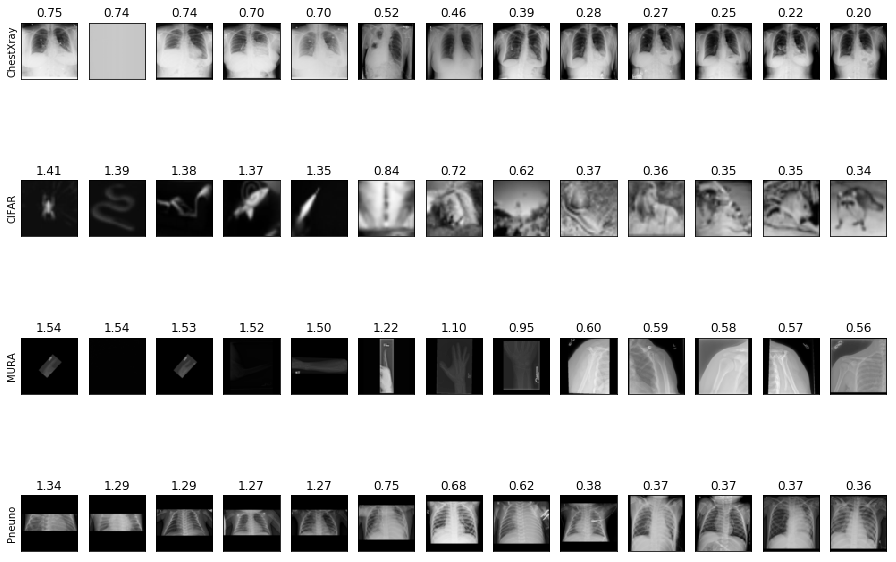

In [14]:

ImageSortPrint(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","CIFAR","MURA","Pneuno","Mean","Shuffle","vFlip"],metric="RecLoss")

In [ ]:
def PrintDense(AllEvalData,DsetName,ToPrint = [],SaveFile="NA",metric="RecLoss"):
    fig = plt.figure(figsize=(15.5,8))
    SNScol = sns.color_palette( n_colors=len(DsetName))
    
    for i,name in enumerate(DsetName):
        if name not in AllEvalData:
            continue
        if metric not in AllEvalData[name]:
            continue
        if len(ToPrint) != 0:
            if name not in ToPrint:
                continue
        #Get Reconstruction loss
        TestRL = AllEvalData[name][metric]
        RealRL = AllEvalData["ChestXray"][metric]

        #Concat
        CatRl = RealRL + TestRL

        #Gen Label
        Lab = [1]*len(RealRL)+[0]*len(TestRL)

        #Get AUC
        fpr, tpr, thresholds = metrics.roc_curve(Lab,-np.array(CatRl), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        lab =  "%s %.2f" % (name,auc)
        if name == "ChestXray":
            lab = name
        #plt.hist(TestRL,label=lab, density=True,histtype="step",bins=20,color=SNScol[i])
        sns.kdeplot(TestRL, shade=True,label=lab,color=SNScol[i])
    #plt.legend(fontsize = 30,frameon=False,prop={"family":"Sans Serif"})
    plt.legend(fontsize = 15,frameon=False)

    plt.xlabel(metric,size=20)
    plt.ylabel("Density",size=20)
    plt.xticks(size=20)
    
    if SaveFile != "NA":
        fig.savefig(SaveFile)
    else:
        plt.show()
    plt.close('all')

[12, 9]


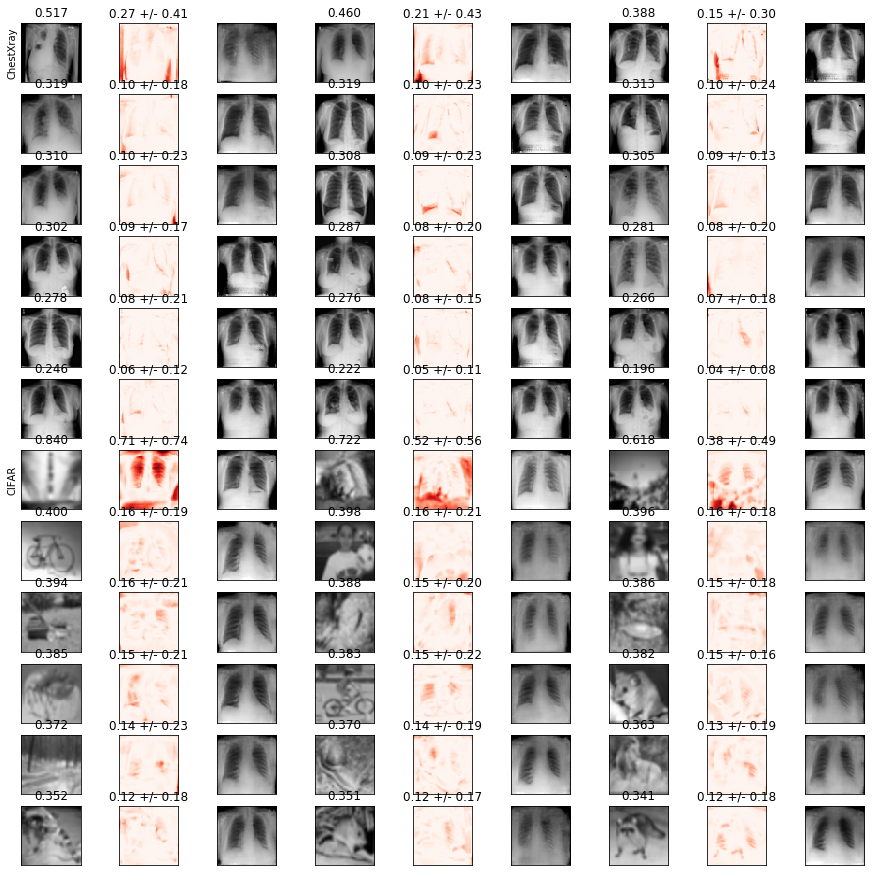

In [15]:
def ImageReconPrint(AllEvalData,DsetName,ToPrint = [],SaveFile="NA",Rows = 2,RowExample=5):

    fig = plt.figure(figsize=(15.5,15.5))
    c = 1
    
    AlphaRed = GetAlphaRedMap()
    
    GS = [len(ToPrint)*Rows,RowExample*3]
    Example = RowExample*Rows
    print(GS)
    
    for i,name in enumerate(DsetName):
        if name not in AllEvalData:
            continue
        if "RecLoss" not in AllEvalData[name]:
            continue
        if len(ToPrint) != 0:
            if name not in ToPrint:
                continue
        RL = AllEvalData[name]["RecLoss"]
        Diff = AllEvalData[name]["DiffX"] 
        img = AllEvalData[name]["X"]
        RB = AllEvalData[name]["Xr"]
        SortInd = np.argsort(RL)[::-1]
        RankPrint = [0,int(len(RL)/4),int(len(RL)/2),int(len(RL)/4*3),len(RL)-1]
        
        RankPrint = [int(len(RL)/4),int(len(RL)/2),int(len(RL)/4*3)]
        for i in range(Example-3):
            RankPrint.append(len(RL)+3-Example+i)
        
        for rp in RankPrint:
            NowInd = SortInd[rp]

            #Plot Init
            plt.subplot(GS[0],GS[1],c)

            plt.imshow(img[NowInd][0],cmap="gray",vmin=-1,vmax=1)
            plt.title("%.3f" % (RL[NowInd]))
            plt.yticks([])
            plt.xticks([])
            if rp == RankPrint[0]:
                plt.ylabel(name)
            c += 1

            #Plt diff
            plt.subplot(GS[0],GS[1],c)
            
            flat = np.ndarray.flatten(Diff[NowInd][0])
            plt.title("%.2f +/- %.2f" % (np.mean(flat),np.std(flat)))
            #plt.title("%.3f" % (RL[NowInd]))
            plt.imshow(Diff[NowInd][0],cmap="Reds",vmin=0, vmax=3)
            plt.yticks([])
            plt.xticks([])
            c += 1

            #Plt Rebuild
            plt.subplot(GS[0],GS[1],c)
            plt.imshow(RB[NowInd][0],cmap="gray",vmin=-1, vmax=1)
            plt.yticks([])
            plt.xticks([])
            c += 1
            

    if SaveFile != "NA":
        fig.savefig(SaveFile)
    else:
        plt.show()
    plt.close('all')
    
ImageReconPrint(AllEvalData,DsetName,ToPrint = ["ChestXray","CIFAR"],SaveFile="NA",Rows=6,RowExample=3)

In [16]:
def get_matches(x1,x2):
    from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
    descriptor_extractor = ORB(n_keypoints=200)

    descriptor_extractor.detect_and_extract(np.double(x1))
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(np.double(x2))
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
    
    plt.gray()
    fig, ax = plt.subplots(nrows=2, ncols=1)
    plot_matches(ax[0], x1, x2, keypoints1, keypoints2, matches12)
    ax[0].axis('off')
    ax[0].set_title("Original Image vs. Transformed Image")
    plt.show()
    return(matches12)



In [17]:
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance

from skimage.measure import compare_ssim as ssim

for n in AllEvalData.keys():
    print(n)
    x = AllEvalData[n]["X"]
    xr = AllEvalData[n]["Xr"]
    W1 = []
    E = []
    SD = []
    for i in range(len(x)):
        d = np.ndarray.flatten((x[i]-xr[i]))
        l2 = np.mean(np.power(d,2))
        l1 = np.mean(np.abs(d))
        w1 = wasserstein_distance(np.ndarray.flatten(x[i]),np.ndarray.flatten(xr[i]))
        e = energy_distance(np.ndarray.flatten(x[i]),np.ndarray.flatten(xr[i]))
        sd = -ssim(x[i][0],xr[i][0])
        #mtch = get_matches(x[i][0],xr[i][0])
        #print(n,len(mtch))
        W1.append(w1)
        E.append(e)
        SD.append(sd)
        AllEvalData[n]["W1"] = W1
        AllEvalData[n]["E"] = E
        AllEvalData[n]["ssim"] = SD

ChestXray
tChestXray
CIFAR
MURA
Pneuno


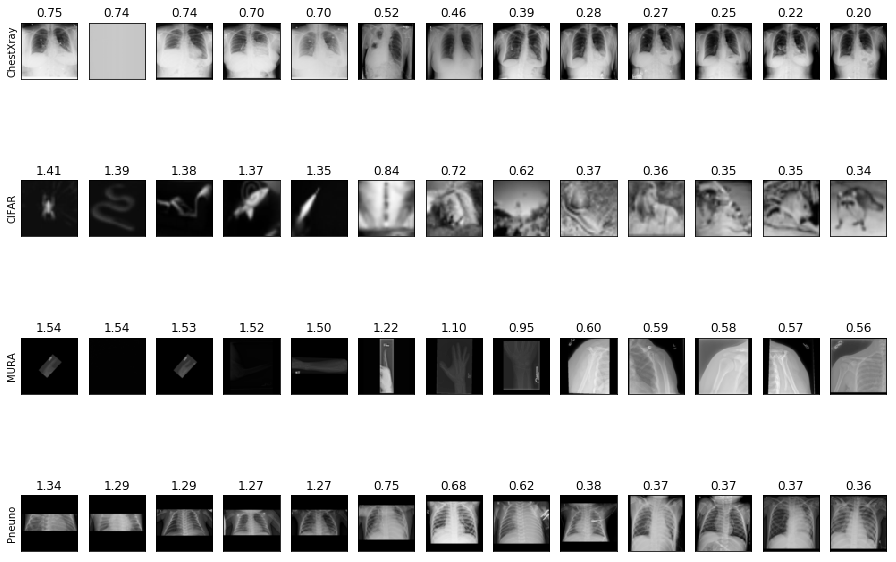

In [22]:

ImageSortPrint(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","CIFAR","MURA","Pneuno","Mean","Shuffle","vFlip"],metric="RecLoss")

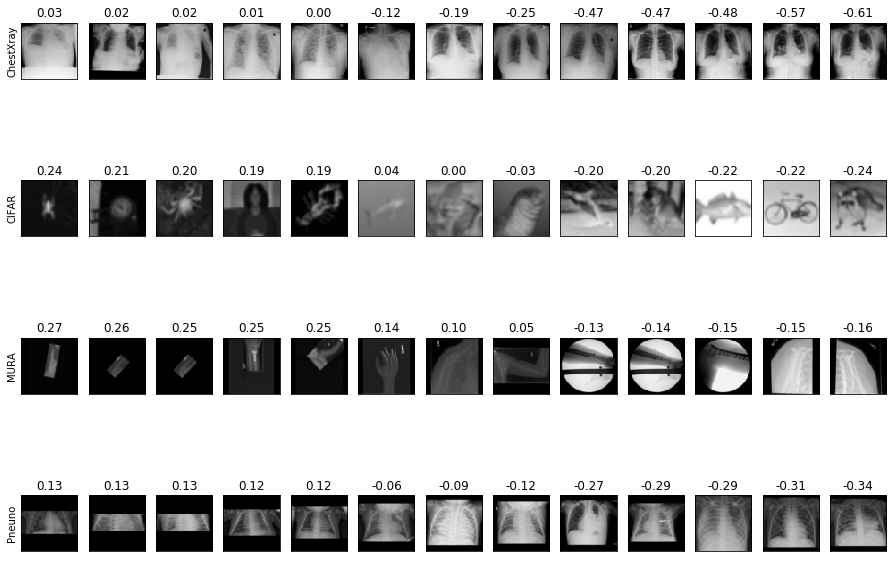

In [23]:

ImageSortPrint(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","CIFAR","MURA","Pneuno","Mean","Shuffle","vFlip"],metric="ssim")

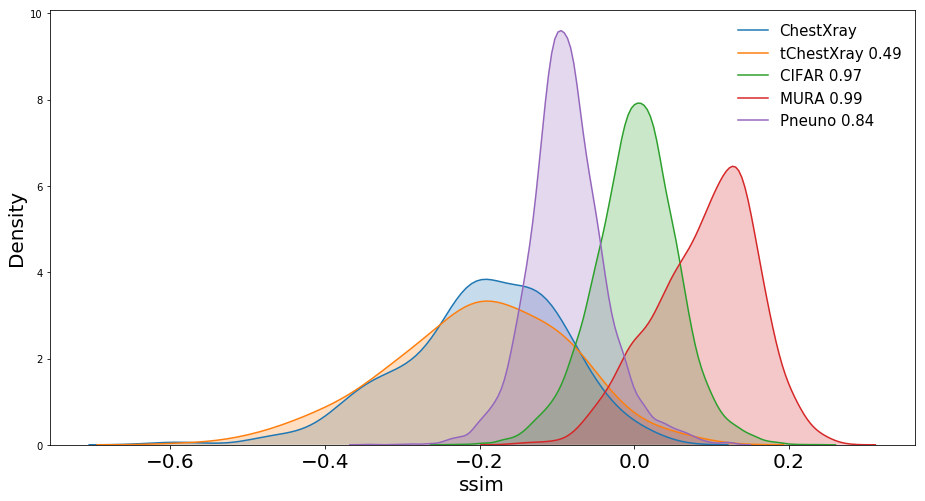

In [28]:
PrintDense(AllEvalData,DsetName,metric="ssim")

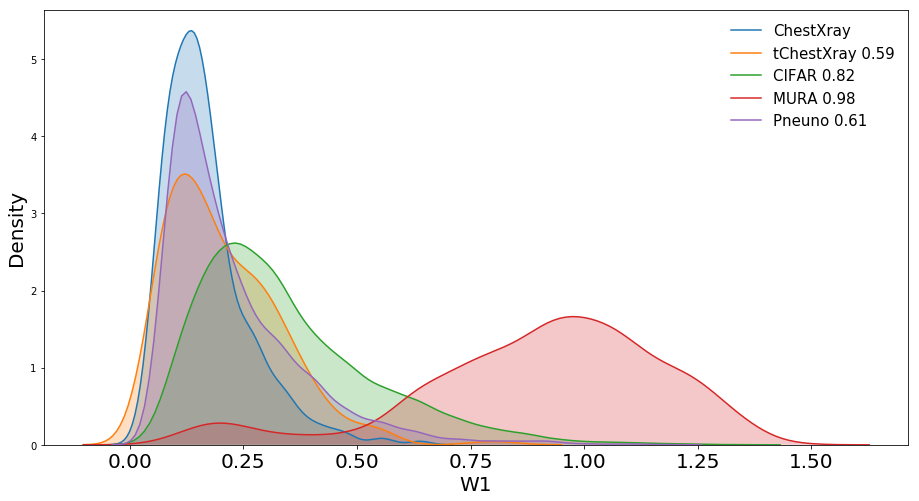

In [30]:
PrintDense(AllEvalData,DsetName,metric="W1")

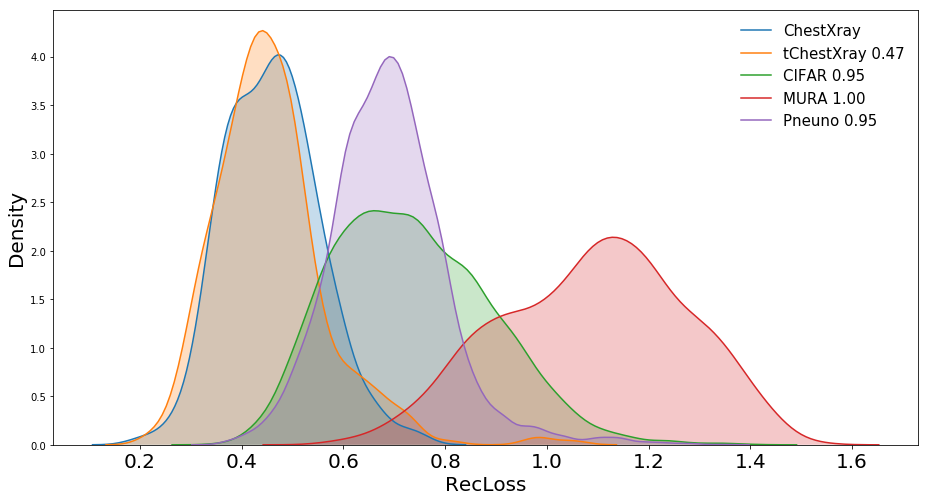

In [31]:
PrintDense(AllEvalData,DsetName,metric="RecLoss")

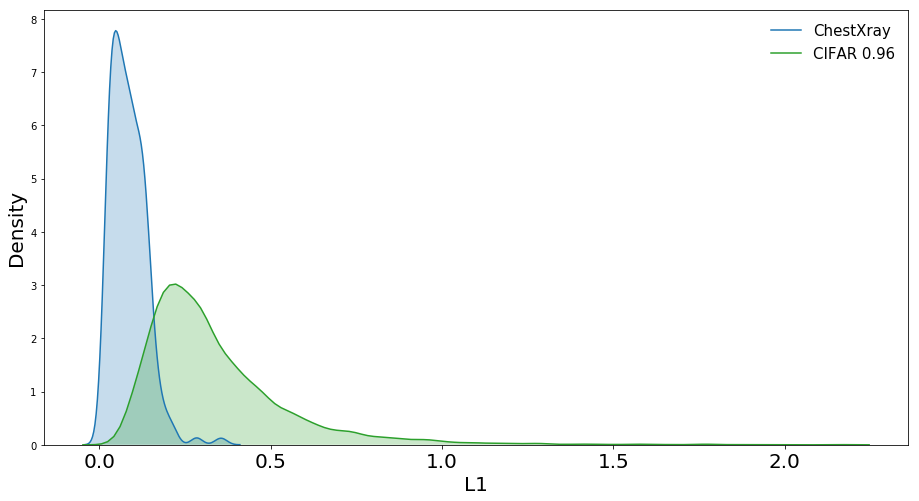

In [27]:
PrintDense(AllEvalData,DsetName,ToPrint=["ChestXray","CIFAR"],metric="L1")

In [ ]:
GetAUC(AllEvalData,metric="L1")

In [ ]:
Zn = AllEvalData["tChestXray"]["Z"]
for name in DsetName:
    tDist = []
    udist = []
    for Zi in AllEvalData[name]["Z"]:
        dist = np.sum(np.power(np.array(Zn)-Zi,2),axis=1)
        tDist.append(np.min(dist))
        udist.append(np.sum(np.power(Zi,2)))
    AllEvalData[name]["tDist"] = tDist
    AllEvalData[name]["Dist"] = udist

In [ ]:

ImageSortPrint(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","CIFAR","MURA","Pneuno","Mean","Shuffle","vFlip"],metric="tDist")

In [ ]:
#ToPrint = ["MNIST","MURA","Shuffle","ChestXray"]
fig = plt.figure(figsize=(15.5,12))
ToPrint = ["ChestXray","tChestXray","MNIST","MURA","Pneuno","CIFAR"]
c = 0
for name in ToPrint:
    RandInd = np.random.randint(len(AllEvalData[n]["Z"]))
    c += 1
    plt.subplot(len(ToPrint),len(ToPrint)+1,c)
    plt.imshow(AllEvalData[name]["X"][RandInd][0],cmap="gray",vmin=-1,vmax=1)
    plt.ylabel(name)
    plt.yticks([])
    plt.xticks([])
    Zi = AllEvalData[name]["Z"][RandInd]
    #Find Closest
    for n1 in ToPrint:
        c += 1
        plt.subplot(len(ToPrint),len(ToPrint)+1,c)
        Zn = AllEvalData[n1]["Z"]
        dist = np.sum(np.power(np.array(Zn)-Zi,2),axis=1)
        ind = np.argsort(dist)[0]
        if n1 == name:
            ind = np.argsort(dist)[1]
        plt.imshow(AllEvalData[n1]["X"][ind][0],cmap="gray",vmin=-1,vmax=1)
        plt.yticks([])
        plt.xticks([])
        plt.title("%.2f" % (dist[ind]))
plt.show()

In [ ]:
#ToPrint = ["MNIST","MURA","Shuffle","ChestXray"]
fig = plt.figure(figsize=(15.5,12))
c = 0



QueryName = "ChestXray"
RL = AllEvalData[QueryName]["tDist"]
RankPrint = [0,1,2,3,4,int(len(RL)/4),int(len(RL)/2),int(len(RL)/4*3),len(RL)-2,len(RL)-1]

PltDim = [len(RankPrint),11]
for rp in RankPrint:
    it = np.argsort(AllEvalData[QueryName]["tDist"])[rp]
    c += 1
    plt.subplot(PltDim[0],PltDim[1],c)
    plt.imshow(AllEvalData[QueryName]["X"][it][0],cmap="gray",vmin=-1,vmax=1)
    plt.ylabel(rp)
    plt.yticks([])
    plt.xticks([])
    Zi = AllEvalData[QueryName]["Z"][it]
    
    
       
    Zn = AllEvalData["tChestXray"]["Z"]
    dist = np.sum(np.power(np.array(Zn)-Zi,2),axis=1)
    inds = np.argsort(dist)
    
    for ind in inds[:10]:
        c+=1
        plt.subplot(PltDim[0],PltDim[1],c)
        plt.imshow(AllEvalData["tChestXray"]["X"][ind][0],cmap="gray",vmin=-1,vmax=1)
        plt.yticks([])
        plt.xticks([])
        plt.title("%.2f" % (dist[ind]))
plt.show()

In [ ]:
Metrics = ["AUCdis","AUCrl","Url","Udis"]
for met in Metrics:
    subdict = dict()
    for cp in AllAUCs:
        subdict[cp] = AllAUCs[cp][met]
        #print(AllAUCs[cp][met])
    df = pd.DataFrame(subdict).transpose()
    for c in sorted(list(df.columns)):
        plt.plot(list(df.index),df[c],label=c)
        plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
        plt.title(met)
        plt.show()

In [ ]:
cp = int(CP)
tAUC = GetAUC(AllEvalData,metric="RecLoss")
if cp not in AllAUCs:
    AllAUCs[cp] = dict()
AllAUCs[cp]["AUCdis"] = tAUC

#Get Loss for every dataset
if "Url" not in AllAUCs[cp]:AllAUCs[cp]["Url"] = dict()
if "Udis" not in AllAUCs[cp]:AllAUCs[cp]["Udis"] = dict()
if "Drl" not in AllAUCs[cp]:AllAUCs[cp]["Drl"] = dict()
if "Ddis" not in AllAUCs[cp]:AllAUCs[cp]["Ddis"] = dict()    
for n in AllEvalData:
    
    AllAUCs[cp]["Url"][n] = np.mean(AllEvalData[n]["RecLoss"])
    AllAUCs[cp]["Udis"][n] = np.mean(AllEvalData[n]["Dis"])

    AllAUCs[cp]["Drl"][n] = np.std(AllEvalData[n]["RecLoss"])
    AllAUCs[cp]["Ddis"][n] = np.std(AllEvalData[n]["Dis"])

pickle.dump(AllAUCs, open( '{0}/models/{1}_AUCs_It_{2}.pth'.format(ExpDir,Params["name"], cp), "wb" ))

In [ ]:
Mean[0]

In [ ]:
AllAUCs.

In [ ]:
cp